In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':13})
import cmocean.cm as cm
from functools import partial
import jax
import warnings
warnings.filterwarnings('ignore')

from veris.area_mass import SeaIceMass, AreaWS
from veris.dynsolver import WindForcingXY, IceVelocities
from veris.dynamics_routines import SeaIceStrength
from veris.ocean_stress import OceanStressUV
from veris.advection import Advection
from veris.clean_up import clean_up_advection, ridging
from veris.fill_overlap import fill_overlap
from initialize_dyn import vs, sett

In [2]:
# veris without thermodynamics
@partial(jax.jit, static_argnames=['sett'])
def dyn_model(vs, sett):

    # calculate sea ice mass centered around c-, u-, and v-points
    vs.SeaIceMassC, vs.SeaIceMassU, vs.SeaIceMassV = SeaIceMass(vs, sett)

    # calculate sea ice cover fraction centered around u- and v-points
    vs.AreaW, vs.AreaS = AreaWS(vs, sett)

    # calculate surface forcing due to wind
    vs.WindForcingX, vs.WindForcingY = WindForcingXY(vs, sett)

    # calculate ice strength
    vs.SeaIceStrength = SeaIceStrength(vs, sett)

    # calculate ice velocities
    vs.uIce, vs.vIce, vs.sigma1, vs.sigma2, vs.sigma12 = IceVelocities(vs, sett)

    # calculate stresses on ocean surface
    vs.OceanStressU, vs.OceanStressV = OceanStressUV(vs, sett)

    # calculate change in sea ice fields due to advection
    vs.hIceMean, vs.hSnowMean, vs.Area = Advection(vs, sett)

    # correct overshoots and other pathological cases after advection
    (
        vs.hIceMean,
        vs.hSnowMean,
        vs.Area,
        vs.TSurf,
        vs.os_hIceMean,
        vs.os_hSnowMean,
    ) = clean_up_advection(vs, sett)

    # cut off ice cover fraction at 1 after advection
    vs.Area = ridging(vs, sett)

    # fill overlaps
    vs.hIceMean = fill_overlap(sett, vs.hIceMean)
    vs.hSnowMean = fill_overlap(sett, vs.hSnowMean)
    vs.Area = fill_overlap(sett, vs.Area)

    return vs

In [3]:
for n_timesteps in range(200):
    vs = dyn_model(vs, sett)

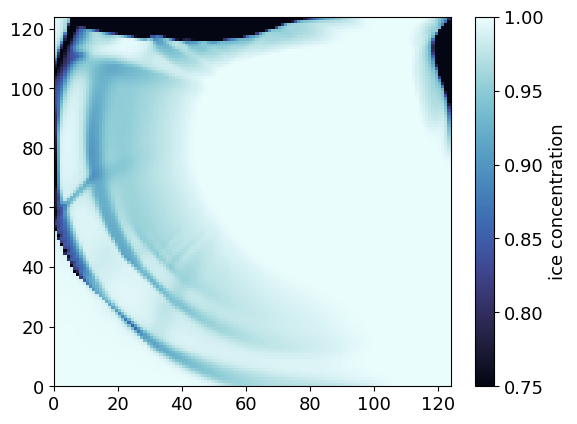

In [4]:
var = vs.Area

plt.pcolormesh(var[2:-2,2:-2].T, vmin=0.75, cmap=cm.ice)
plt.colorbar(label='ice concentration')